In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd /content/gdrive/My\ Drive/Digikala

/content/gdrive/My Drive/Digikala


In [0]:
df = pd.read_csv('twitter/train_cleaned_final4.csv')

In [0]:
X = df['text']
y = df['target']

In [0]:
# train = pd.read_csv('balance_classified_train.csv')
# valid = pd.read_csv('balance_classified_valid.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# train_x = train['comment']
# valid_x = valid['comment']
# train_y = train['target']
# valid_y = valid['target']

In [0]:
# from keras.utils import to_categorical
# y_binary = to_categorical(y)

# train_y = to_categorical(train_y)
# valid_y = to_categorical(valid_y)

In [0]:
# Split train data into train and validation
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.3)

In [0]:
train_labels = train_y
valid_labels = valid_y

In [0]:
print(train_x.shape, valid_x.shape)
print(train_y.shape, valid_y.shape)

(5329,) (2284,)
(5329,) (2284,)


In [0]:
# vocab_size = 120716
# embedding_dim = 30
# max_length = 30
vocab_size = 10000
embedding_dim = 60
max_length = 120
trunc_type='post'

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 50)
tokenizer.fit_on_texts(train_x)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_x)
valid_sequences = tokenizer.texts_to_sequences(valid_x)

Using TensorFlow backend.


In [0]:
# get only the top frequent words on train
train_data = pad_sequences(train_sequences, padding = "post", maxlen = max_length)
# get only the top frequent words on test
valid_data = pad_sequences(valid_sequences, padding = "post", maxlen = max_length)

In [0]:
print(train_data.shape, valid_data.shape)

(5329, 30) (2284, 30)


In [0]:
train_data_reshaped = np.array(train_data).reshape((train_data.shape[0], train_data.shape[1], 1))
valid_data_reshaped = np.array(valid_data).reshape((valid_data.shape[0], valid_data.shape[1], 1))

In [0]:
print(train_data_reshaped.shape, valid_data_reshaped.shape)

(5329, 30, 1) (2284, 30, 1)


In [0]:
print(train_data.shape)
print(valid_data.shape)
print(train_y.shape)
print(valid_y.shape)

(5329, 30)
(2284, 30)
(5329,)
(2284,)


In [0]:
from keras.layers import  Concatenate, Permute, Dot, Input, multiply, LSTM, GRU, TimeDistributed
from keras.layers import RepeatVector, Dense, Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dropout, Embedding, Activation, Lambda, Reshape
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU ,regularizers
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import load_model, Model
import keras.backend as K
import numpy as np


In [0]:
#Attention Class
class Attention(Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 =Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
 
    def call(self, features, hidden):
        hidden_with_time_axis = expand_dims(hidden, 1)
        score = nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

#Attention function
def Att1_layer(output, units):
    attention = Dense(embedding_dim)(output)
    attention = Permute((2,1))(attention)
    attention = Activation('softmax', name='attention_vec')(attention)
    attention = Permute((2,1))(attention)
    attention = Lambda(lambda x: K.mean(x,axis=2), name='attention', output_shape=(int(output.shape[1]),))(attention)
    attention = RepeatVector(units)(attention)
    attention = Permute((2,1))(attention)
    output = multiply([output,attention])

    return output

 #Attention2 function
def Att2_layer(output, units):
    attention = Dense(1, activation='tanh')(output)
    attention = Flatten()(attention)
    attention = Activation('softmax', name='attention_vec2')(attention)
    attention = RepeatVector(units)(attention)
    attention = Permute([2, 1])(attention)    
    attention = multiply([output,attention])

    return attention        

 #Attention3 function
def Att3_layer(output, units):
    attention = TimeDistributed(Dense(1, activation='tanh'))(output) 
    attention = Flatten()(attention)
    attention = Activation('softmax', name='attention_vec3')(attention)
    attention = RepeatVector(units)(attention)
    attention = Permute([2, 1])(attention) 

    attention = multiply([activations, attention])
    attention = Lambda(lambda xin: K.sum(xin, axis=1))(attention)
    return attention    

##Attentional GRU

In [0]:
units = 250

#GRU Layer
sequence_input = Input(shape=(max_length,))
embedded_sequences = Embedding(vocab_size, embedding_dim, input_length=max_length)(sequence_input)
activations = GRU(units, return_sequences=False)(embedded_sequences)

#Attention Layer
# attention = Att3_layer(activations,units)

#GRU Layer
output = Dense(1, activation='sigmoid')(activations)

model2 = Model(inputs=sequence_input, outputs=output)
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 120)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 120, 60)           600000    
_________________________________________________________________
gru_3 (GRU)                  (None, 250)               233250    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 251       
Total params: 833,501
Trainable params: 833,501
Non-trainable params: 0
_________________________________________________________________


In [0]:
model2.compile(loss = 'binary_crossentropy', optimizer= 'Adam', metrics = ['accuracy'])

In [0]:
history = model2.fit(train_data, train_labels, epochs=10, batch_size=512, validation_data = (valid_data, valid_labels), verbose=1)

Train on 5329 samples, validate on 2284 samples
Epoch 1/10
5329/5329 [==============================] - 4s 805us/step - loss: 0.6861 - acc: 0.5695 - val_loss: 0.6827 - val_acc: 0.5722
Epoch 2/10
5329/5329 [==============================] - 3s 613us/step - loss: 0.6836 - acc: 0.5695 - val_loss: 0.6829 - val_acc: 0.5722
Epoch 3/10
5329/5329 [==============================] - 3s 618us/step - loss: 0.6838 - acc: 0.5695 - val_loss: 0.6827 - val_acc: 0.5722
Epoch 4/10
5329/5329 [==============================] - 3s 616us/step - loss: 0.6835 - acc: 0.5695 - val_loss: 0.6829 - val_acc: 0.5722
Epoch 5/10
5329/5329 [==============================] - 3s 611us/step - loss: 0.6835 - acc: 0.5695 - val_loss: 0.6827 - val_acc: 0.5722
Epoch 6/10
5329/5329 [==============================] - 3s 614us/step - loss: 0.6836 - acc: 0.5695 - val_loss: 0.6827 - val_acc: 0.5722
Epoch 7/10
5329/5329 [==============================] - 3s 614us/step - loss: 0.6836 - acc: 0.5695 - val_loss: 0.6829 - val_acc: 0.5722


In [0]:
results = model2.evaluate(valid_data, valid_labels)
print('Test accuracy: ', results[1])

2284/2284 [==============================] - 1s 578us/step
Test accuracy:  0.6453590192644484


In [0]:
print(model2.layers)

[<keras.engine.input_layer.InputLayer object at 0x7f7eac09db70>, <keras.layers.embeddings.Embedding object at 0x7f7eabfd8ba8>, <keras.layers.recurrent.GRU object at 0x7f7eabfd8630>, <keras.layers.wrappers.TimeDistributed object at 0x7f7eabf41dd8>, <keras.layers.core.Flatten object at 0x7f7eabf418d0>, <keras.layers.core.Activation object at 0x7f7eabf11a90>, <keras.layers.core.RepeatVector object at 0x7f7eabf11978>, <keras.layers.core.Permute object at 0x7f7eabf16780>, <keras.layers.merge.Multiply object at 0x7f7eabf16da0>, <keras.layers.core.Lambda object at 0x7f7eabf16c88>, <keras.layers.core.Dense object at 0x7f7eabf85f98>]


In [0]:
g = model2.layers[5].get_config()
h = model2.layers[5].get_weights()
print(g)
print(h)

{'name': 'attention_vec3', 'trainable': True, 'dtype': 'float32', 'activation': 'softmax'}
[]


##Attentional LSTM

In [0]:
#another attention layer for LSTM
sequence_input = Input(shape=(max_length,), dtype='int32')
embedded = Embedding(vocab_size, embedding_dim, input_length=max_length)(sequence_input)
activations = LSTM(units, dropout=0.4, return_sequences=True)(embedded)
activations = Dropout(0.4)(activations)

#Attention Layer
# attention = Att2_layer(activations, units)

#LSTM Layers
activations = Flatten()(activations)
activations = Dense(6, activation='relu')(activations)
output = Dense(1, activation='sigmoid')(activations)

model3 = Model(inputs=sequence_input, outputs=output)
model3.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 120)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 120, 60)           600000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 250)          311000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 250)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 180006    
_________

In [0]:
model3.compile(loss = 'binary_crossentropy', optimizer= 'Adam', metrics = ['accuracy'])
history3= model3.fit(train_data, train_labels, epochs=10, batch_size=512, validation_data = (valid_data, valid_labels), verbose=1)

Train on 5329 samples, validate on 2284 samples
Epoch 1/10
5329/5329 [==============================] - 6s 1ms/step - loss: 0.6859 - acc: 0.5665 - val_loss: 0.6818 - val_acc: 0.5722
Epoch 2/10
5329/5329 [==============================] - 4s 810us/step - loss: 0.6834 - acc: 0.5695 - val_loss: 0.6791 - val_acc: 0.5722
Epoch 3/10
5329/5329 [==============================] - 4s 806us/step - loss: 0.6753 - acc: 0.5695 - val_loss: 0.6641 - val_acc: 0.5722
Epoch 4/10
5329/5329 [==============================] - 4s 817us/step - loss: 0.6565 - acc: 0.5735 - val_loss: 0.6579 - val_acc: 0.5722
Epoch 5/10
5329/5329 [==============================] - 4s 811us/step - loss: 0.6481 - acc: 0.6110 - val_loss: 0.6394 - val_acc: 0.6121
Epoch 6/10
5329/5329 [==============================] - 4s 812us/step - loss: 0.6220 - acc: 0.6361 - val_loss: 0.6318 - val_acc: 0.6331
Epoch 7/10
5329/5329 [==============================] - 4s 816us/step - loss: 0.6163 - acc: 0.6467 - val_loss: 0.6266 - val_acc: 0.6344
Ep

##Attentional CNN

In [0]:
units = 320
#cnn Layer
sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = Embedding(vocab_size, embedding_dim, input_length=max_length)(sequence_input)
output = Conv1D(units, kernel_size=26, padding='valid', activation='relu')(embedded_sequences)
output = MaxPooling1D(pool_size=4, strides=4)(output)
output = Dropout(0.2)(output)

#Attention Layer
output = Att2_layer(output, units)

#conv Layer
output = Flatten()(output)
output = Dense(6, activation='relu')(output)
output = Dense(1, activation='sigmoid')(output)

model4 = Model(inputs=sequence_input, outputs=output)
model4.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 120, 60)      600000      input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 95, 320)      499520      embedding_8[0][0]                
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 23, 320)      0           conv1d_4[0][0]                   
____________________________________________________________________________________________

In [0]:
model4.compile(loss = 'binary_crossentropy', optimizer= 'Adam', metrics = ['accuracy'])

In [0]:
history = model4.fit(train_data, train_labels, epochs=10, batch_size=512, validation_data = (valid_data, valid_labels), verbose=1)

Train on 5329 samples, validate on 2284 samples
Epoch 1/10
5329/5329 [==============================] - 2s 440us/step - loss: 0.6903 - acc: 0.5675 - val_loss: 0.6837 - val_acc: 0.5722
Epoch 2/10
5329/5329 [==============================] - 1s 191us/step - loss: 0.6840 - acc: 0.5695 - val_loss: 0.6827 - val_acc: 0.5722
Epoch 3/10
5329/5329 [==============================] - 1s 190us/step - loss: 0.6843 - acc: 0.5695 - val_loss: 0.6831 - val_acc: 0.5722
Epoch 4/10
5329/5329 [==============================] - 1s 192us/step - loss: 0.6837 - acc: 0.5695 - val_loss: 0.6827 - val_acc: 0.5722
Epoch 5/10
5329/5329 [==============================] - 1s 192us/step - loss: 0.6836 - acc: 0.5695 - val_loss: 0.6827 - val_acc: 0.5722
Epoch 6/10
5329/5329 [==============================] - 1s 192us/step - loss: 0.6835 - acc: 0.5695 - val_loss: 0.6825 - val_acc: 0.5722
Epoch 7/10
5329/5329 [==============================] - 1s 192us/step - loss: 0.6838 - acc: 0.5695 - val_loss: 0.6823 - val_acc: 0.5722


##Attentional CNN2 - best model 

In [0]:
units = 320
#cnn2 layer
sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = Embedding(vocab_size, embedding_dim, input_length=max_length)(sequence_input)
output = Conv1D(units, kernel_size=26, padding='same', activation='relu')(embedded_sequences)
output = MaxPooling1D(pool_size=13, padding='same')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.5)(output)
output = Conv1D(units, kernel_size=26, padding='same', activation='relu')(output)
output = MaxPooling1D(pool_size=13, strides=13, padding='same')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.2)(output)

#Attention Layer
# output = Att2_layer(output, units)

#cnn2 layer
output = Flatten()(output)
output = Dense(6)(output)
output = Dense(1)(output)
output = Activation('sigmoid')(output)


model5 = Model(inputs=sequence_input, outputs=output)
model5.summary()


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 120)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 120, 60)           600000    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 120, 320)          499520    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 10, 320)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 320)           1280      
_________________________________________________________________
activation_4 (Activation)    (None, 10, 320)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 320)           0   

In [0]:
model5.compile(loss='binary_crossentropy', optimizer = 'Adam' , metrics=['accuracy'])

In [0]:
history = model5.fit(train_data, train_labels, batch_size = 512, validation_data = (valid_data, valid_labels), epochs = 10, verbose = 1 )

Train on 5329 samples, validate on 2284 samples
Epoch 1/10
5329/5329 [==============================] - 4s 819us/step - loss: 0.8586 - acc: 0.5356 - val_loss: 1.3443 - val_acc: 0.5722
Epoch 2/10
5329/5329 [==============================] - 2s 416us/step - loss: 0.7999 - acc: 0.5562 - val_loss: 1.0483 - val_acc: 0.6081
Epoch 3/10
5329/5329 [==============================] - 2s 416us/step - loss: 0.7090 - acc: 0.5949 - val_loss: 1.0894 - val_acc: 0.4650
Epoch 4/10
5329/5329 [==============================] - 2s 418us/step - loss: 0.6927 - acc: 0.6335 - val_loss: 1.3125 - val_acc: 0.4291
Epoch 5/10
5329/5329 [==============================] - 2s 417us/step - loss: 0.6752 - acc: 0.6393 - val_loss: 1.1367 - val_acc: 0.4645
Epoch 6/10
5329/5329 [==============================] - 2s 418us/step - loss: 0.6527 - acc: 0.6491 - val_loss: 0.9159 - val_acc: 0.4580
Epoch 7/10
5329/5329 [==============================] - 2s 416us/step - loss: 0.6417 - acc: 0.6545 - val_loss: 0.7079 - val_acc: 0.5026


In [0]:
results = model5.evaluate(valid_data, valid_labels)
print('Test accuracy: ', results[1])

2284/2284 [==============================] - 0s 183us/step
Test accuracy:  0.6094570929240011


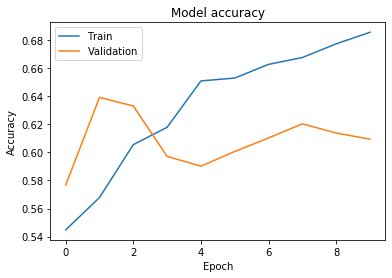

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

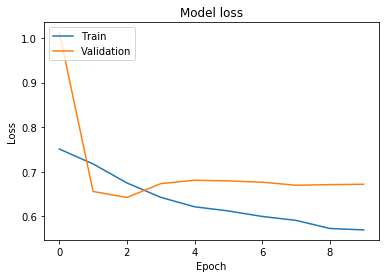

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
plot_model(model5, to_file='cnn_model5.png')

In [0]:
units = 320
#cnn2 layer
sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = Embedding(vocab_size, embedding_dim, input_length=max_length)(sequence_input)
output = Conv1D(units, kernel_size=26, padding='same', activation='relu')(embedded_sequences)
output = MaxPooling1D(pool_size=13, padding='same')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.5)(output)
output = Conv1D(units, kernel_size=26, padding='same', activation='relu')(output)
output = MaxPooling1D(pool_size=13, strides=13, padding='same')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.2)(output)

#Attention Layer
# output = Att1_layer(output, units)

#cnn2 layer
output = Flatten()(output)
output = Dense(6)(output)
output = Dense(1)(output)
output = Activation('sigmoid')(output)


model6 = Model(inputs=sequence_input, outputs=output)
model6.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 120)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 120, 60)           600000    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 120, 320)          499520    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 10, 320)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 320)           1280      
_________________________________________________________________
activation_10 (Activation)   (None, 10, 320)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 10, 320)           0  

In [0]:
model6.compile(loss='binary_crossentropy', optimizer = 'Adam' , metrics=['accuracy'])

In [0]:
history = model6.fit(train_data, train_labels, batch_size = 512, validation_data = (valid_data, valid_labels), epochs = 10, verbose = 1 )

Train on 5329 samples, validate on 2284 samples
Epoch 1/10
5329/5329 [==============================] - 5s 938us/step - loss: 0.8073 - acc: 0.5314 - val_loss: 1.2803 - val_acc: 0.5709
Epoch 2/10
5329/5329 [==============================] - 2s 413us/step - loss: 0.7447 - acc: 0.5603 - val_loss: 0.7216 - val_acc: 0.5911
Epoch 3/10
5329/5329 [==============================] - 2s 419us/step - loss: 0.7182 - acc: 0.5986 - val_loss: 0.9358 - val_acc: 0.6187
Epoch 4/10
5329/5329 [==============================] - 2s 415us/step - loss: 0.6792 - acc: 0.6178 - val_loss: 0.7241 - val_acc: 0.6213
Epoch 5/10
5329/5329 [==============================] - 2s 415us/step - loss: 0.6614 - acc: 0.6433 - val_loss: 0.6554 - val_acc: 0.6064
Epoch 6/10
5329/5329 [==============================] - 2s 414us/step - loss: 0.6377 - acc: 0.6483 - val_loss: 0.6617 - val_acc: 0.6055
Epoch 7/10
5329/5329 [==============================] - 2s 417us/step - loss: 0.6322 - acc: 0.6573 - val_loss: 0.6805 - val_acc: 0.5863


In [0]:
results = model6.evaluate(valid_data, valid_labels)

35615/35615 [==============================] - 8s 215us/step


In [0]:
print('Test accuracy: ', results[1])

Test accuracy:  0.7170293415745841


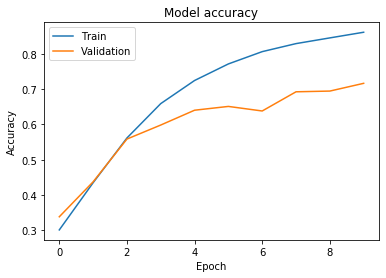

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

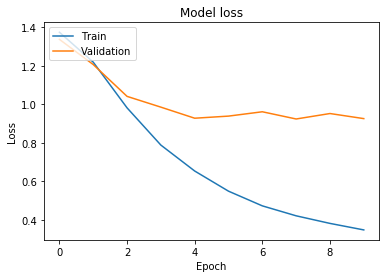

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
plot_model(model6, to_file='cnn_model6.png')